In [132]:
import os
os.path

from datetime import datetime, timedelta
import cmocean

import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import trajan as ta
import pandas as pd

import opendrift
from opendrift.models.oceandrift import OceanDrift
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.physics_methods import wind_drift_factor_from_trajectory, distance_between_trajectories, skillscore_liu_weissberg

import cartopy.crs as ccrs
from matplotlib.lines import Line2D

from scipy.spatial import ConvexHull, convex_hull_plot_2d

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

In [133]:
d03 = xr.open_dataset('C:/Users/bente/Documents/BACKTRACK/backtracking/data/OO-2023.nc')       # all drifter data
d03 = d03.traj.gridtime('1H')
d03 = d03.isel(trajectory=0)             # drifter OO-2023-03

In [134]:
startlat = d03.lat.sel(time=slice(datetime(2023, 1, 30, 3, 12, 8), datetime(2023, 1, 30, 3, 12, 8))).values
startlon = d03.lon.sel(time=slice(datetime(2023, 1, 30, 3, 12, 8), datetime(2023, 1, 30, 3, 12, 8))).values

In [135]:
len(hits[0])

34

In [136]:
reader_globcur = reader_netCDF_CF_generic.Reader("C:/Users/bente/Documents/THESIS/Globcurrent/*.nc")

10:19:30 INFO    opendrift.readers.reader_netCDF_CF_generic:129: Opening dataset: C:/Users/bente/Documents/THESIS/Globcurrent/*.nc
10:19:30 INFO    opendrift.readers.reader_netCDF_CF_generic:131: Opening files with MFDataset
10:19:32 DEBUG   opendrift.readers.reader_netCDF_CF_generic:146: Finding coordinate variables.
10:19:32 DEBUG   opendrift.readers.reader_netCDF_CF_generic:163: Parsing CF grid mapping dictionary: {'grid_mapping_name': 'latitude_longitude', 'semi_major_axis': 6378137, 'inverse_flattening': 298.257223563}
10:19:32 INFO    opendrift.readers.reader_netCDF_CF_generic:170: Could not parse CF grid_mapping
10:19:32 INFO    opendrift.readers.reader_netCDF_CF_generic:285: Grid coordinates are detected, but proj4 string not given: assuming latlong
10:19:32 DEBUG   opendrift.readers.basereader.variables:546: Setting buffer size 6 for reader C:/Users/bente/Documents/THESIS/Globcurrent/*.nc, assuming a maximum average speed of 5 m/s and time span of 6:00:00
10:19:32 INFO    open

In [137]:
duration = timedelta(hours=120)                # 2 days
start_time = datetime(2023,1,25,3,12,8)
end_time = start_time + duration

In [143]:
outfile_bwd = "D:/backtrack/oceandrift_48h/likelihood/bwd2530jan34.nc"

In [80]:
orev = OceanDrift(loglevel=50)
orev.add_reader([reader_globcur])
orev.set_config('drift:advection_scheme', 'runge-kutta4')
orev.seed_elements(lon=startlon, lat=startlat, radius=10000, radius_type='uniform', number=34, time=end_time)
orev.run(duration=duration, time_step=-900, time_step_output=3600, outfile=outfile_bwd)

17:13:46 DEBUG   opendrift.models.oceandrift:112: No machine learning correction available.


In [144]:
back34 = xr.open_dataset(outfile_bwd)

In [24]:
diflon = np.max(back.isel(time=120).lon.values) - np.min(back.isel(time=120).lon.values)
diflat = np.max(back.isel(time=120).lat.values) - np.min(back.isel(time=120).lat.values)

In [25]:
diflat

2.8790474

In [26]:
# Define domain of possible origin !!! WITH RANDOM UNIFORM SEEDING !!!
lons = np.zeros((120,120))
lats = np.zeros((120,120))
for j in range(120):
    lons[j] = np.random.uniform(np.min(back.isel(time=120).lon.values)-(0.5), np.max(back.isel(time=120).lon.values)+(0.5), 120) # Much coarser CCC
    lats[j] = np.random.uniform(np.min(back.isel(time=120).lat.values)-(0.5), np.max(back.isel(time=120).lat.values)+(0.5), 120)

In [27]:
np.min(back.lat.values)

-40.695507

In [28]:
np.max(back.lat.values)

-37.479378

In [31]:
outfile = "D:/backtrack/oceandrift_48h/likelihood/fwd2530feb2.nc"

In [32]:
ofwd = OceanDrift(loglevel=50)
ofwd.add_reader([reader_globcur])
ofwd.set_config('drift:advection_scheme', 'runge-kutta4')
ofwd.seed_elements(lon=lons, lat=lats, radius=0, time=start_time)
ofwd.run(duration=duration, time_step=900, time_step_output=3600, outfile=outfile)

In [33]:
fwd = xr.open_dataset(outfile)

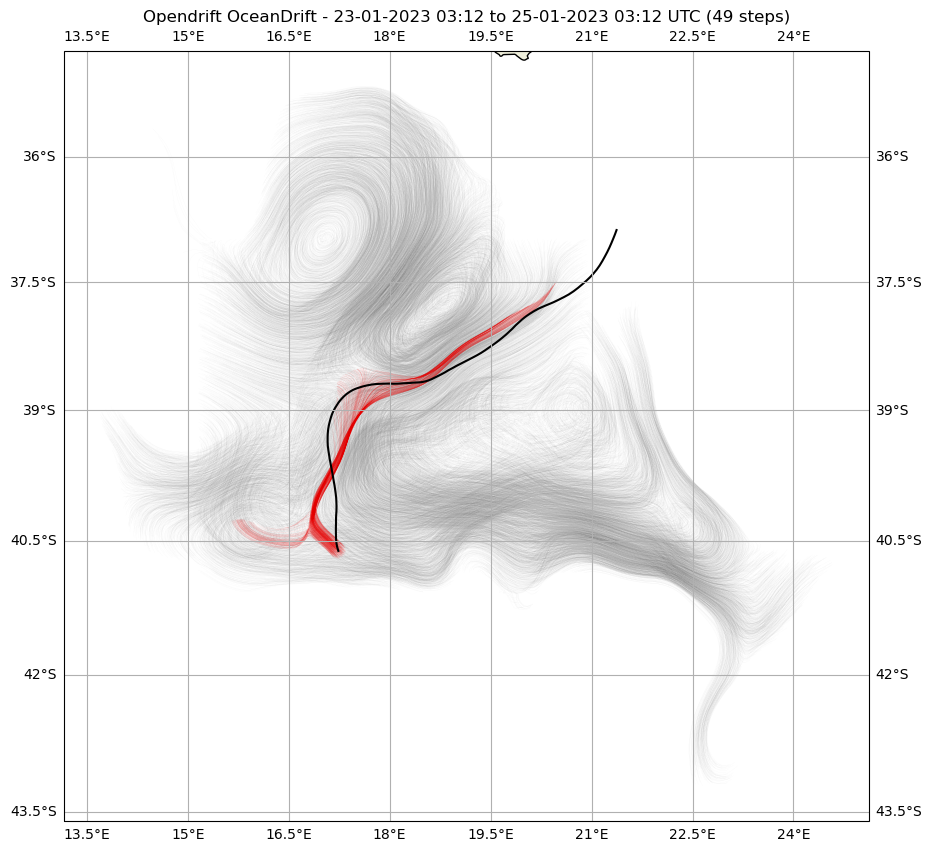

In [34]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS)

fwd.traj.plot(linewidth=0.1)

back.traj.plot(linewidth=0.1,color='red')

d03.sel(time=slice('2023-01-25 03:12:08', '2023-01-30 03:12:08')).traj.plot(color='black')  

plt.gca().autoscale()
plt.title('Opendrift OceanDrift - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show() 

In [37]:
ilat = d03.lat.sel(time=slice(datetime(2023, 1, 30, 3, 12, 8), datetime(2023, 1, 30, 3, 12, 8))).values
ilon = d03.lon.sel(time=slice(datetime(2023, 1, 30, 3, 12, 8), datetime(2023, 1, 30, 3, 12, 8))).values

In [39]:
## FORWARD ## 
lon0 = []
lat0 = []
lonend0 = []
latend0 = []
for j in range(len(fwd.trajectory)):
        ### calculating hits ###
        lon0.append(fwd.isel(trajectory=j).lon.values)
        lat0.append(fwd.isel(trajectory=j).lat.values)
        lonend0.append(fwd.isel(trajectory=j).lon.values[-1])   # lon at end of trajectory
        latend0.append(fwd.isel(trajectory=j).lat.values[-1])   # lat at end of trajectory
        
geod = pyproj.Geod(ellps='WGS84')
on = np.ones(len(lonend0))
dummy1, dummy2, dist2incident = geod.inv(lonend0, latend0, ilon*on, ilat*on)
hits = np.where(dist2incident<10000)

hit_start_lons0= []
hit_start_lats0= []
for m in range(len(hits)):
        hit_start_lons0.append(lon0[hits[0][m]][0])
        hit_start_lats0.append(lat0[hits[0][m]][0])

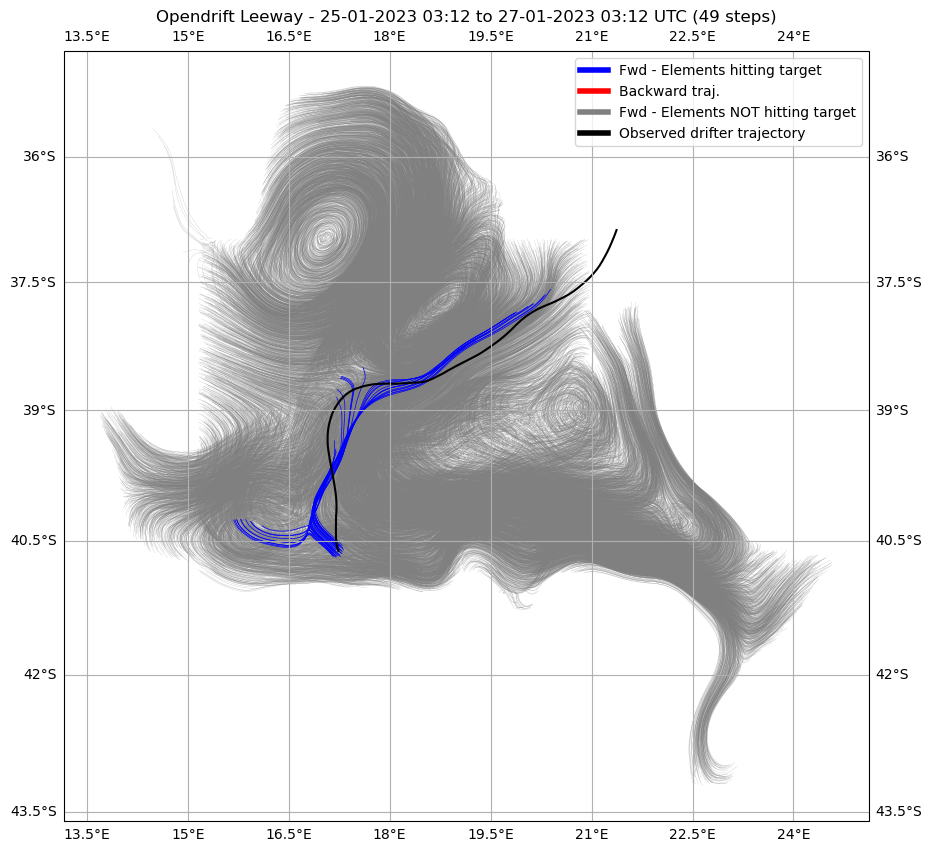

In [40]:
### PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(fwd.trajectory)):
    fwd.isel(trajectory=i).traj.plot(linewidth=0.1)
    
for i in hits: 
    fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='blue')
#     ax.plot(fwd.isel(trajectory=i).isel(time=48).lon.values, fwd.isel(trajectory=i).isel(time=48).lat.values, 'bo', mec='black', markersize=7, transform=ccrs.Geodetic())
#     ax.plot(fwd.isel(trajectory=i).isel(time=0).lon.values, fwd.isel(trajectory=i).isel(time=0).lat.values, 'bo', mec='black', markersize=7, transform=ccrs.Geodetic())

# for i in range(len(fwd.trajectory)):
#     fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='red')
#     ax.plot(fwd.isel(trajectory=i).isel(time=48).lon.values, fwd.isel(trajectory=i).isel(time=48).lat.values, 'ro', mec='black', markersize=7, transform=ccrs.Geodetic())

d03.sel(time=slice('2023-01-25 03:12:08', '2023-01-30 03:12:08')).traj.plot(color='black')  

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)]

ax.legend(custom_lines, ['Fwd - Elements hitting target','Backward traj.', 'Fwd - Elements NOT hitting target', 'Observed drifter trajectory'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 25-01-2023 03:12 to 27-01-2023 03:12 UTC (49 steps)')
plt.show()

In [41]:
np.where(dist2incident<5000)

(array([ 1165,  3705,  6308,  6508,  6696,  8787,  9104,  9712,  9858,
        11080, 13857], dtype=int64),)

In [42]:
hits[0]

array([ 1165,  1277,  1474,  1699,  1714,  2103,  2954,  3705,  3753,
        4811,  4978,  6308,  6508,  6696,  7342,  7850,  8132,  8147,
        8787,  9078,  9104,  9208,  9712,  9858,  9868, 10274, 10405,
       10758, 10812, 11026, 11080, 12145, 13857, 13978], dtype=int64)

In [43]:
len(hits[0])

34

In [44]:
o_hit = opendrift.open(outfile, elements=hits[0])

17:05:48 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
17:05:48 DEBUG   opendrift.models.basemodel:618: Adding 5 config items from basemodel
17:05:48 DEBUG   opendrift.models.basemodel:618: Adding 36 config items from basemodel
17:05:48 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
17:05:48 DEBUG   opendrift.models.basemodel:618: Adding 14 config items from oceandrift
17:05:48 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:z
17:05:48 DEBUG   opendrift.export.io_netcdf:267: Importing from D:/backtrack/oceandrift_48h/likelihood/fwd2530feb2.nc
17:05:50 DEBUG   opendrift.models.basemodel:2449: No elements to deactivate
17:05:50 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:use_auto_landmask -> True
17:05:50 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:coastline_action -> stranding
17:05:50 DEBUG   opendrift.export.io_netcdf:365: Setting i

17:05:50 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:constant:surface_downward_y_stress -> None
17:05:50 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:fallback:surface_downward_y_stress -> 0
17:05:50 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:constant:turbulent_kinetic_energy -> None
17:05:50 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:fallback:turbulent_kinetic_energy -> 0
17:05:50 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:constant:turbulent_generic_length_scale -> None
17:05:50 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:fallback:turbulent_generic_length_scale -> 0
17:05:50 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:constant:ocean_mixed_layer_thickness -> None
17:05:50 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:fallback:o

17:05:50 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=False, lscale=None
17:05:50 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (15.283462142944334, 20.788746261596682, -40.87970275878906, -37.381050872802724)..
17:05:56 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (15.283462142944334, 20.788746261596682, -40.87970275878906, -37.381050872802724)..
17:05:56 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (15.283462142944334, 20.788746261596682, -40.87970275878906, -37.381050872802724)..


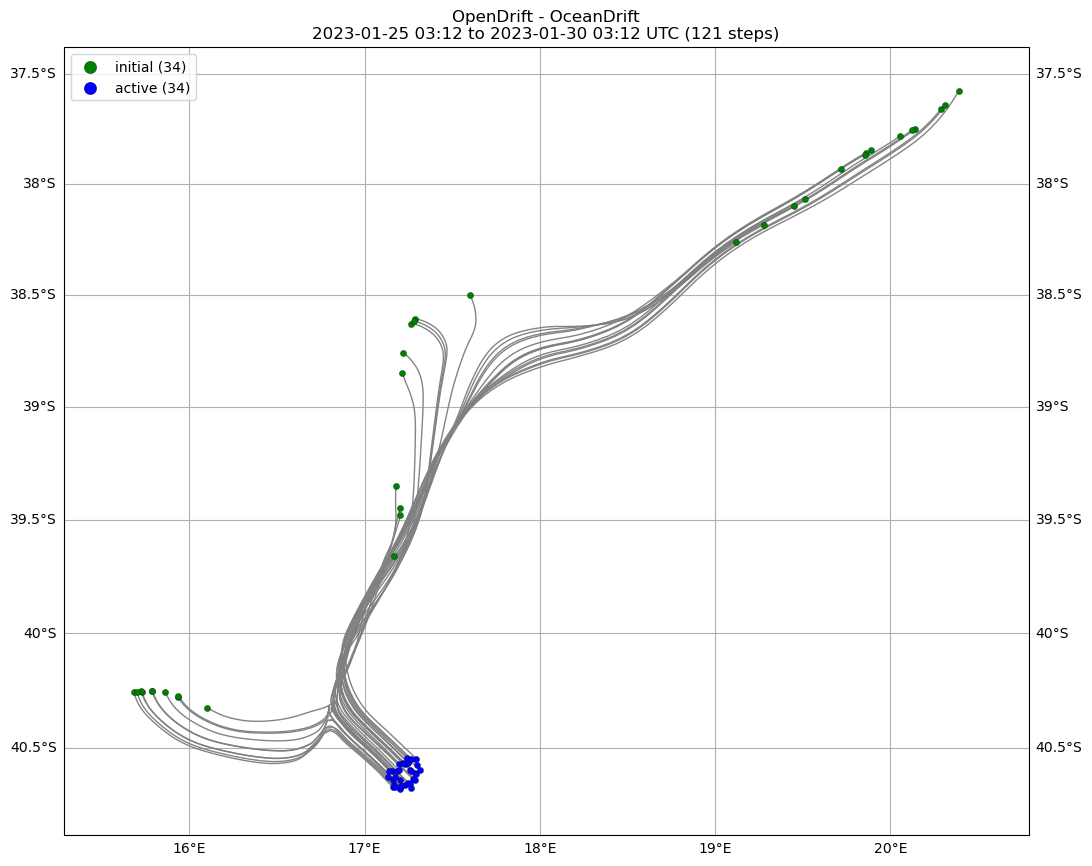

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-01-25 03:12 to 2023-01-30 03:12 UTC (121 steps)'}>,
 <Figure size 1100x901.183 with 1 Axes>)

In [45]:
o_hit.plot()

In [50]:
of.get_histogram(pixelsize_m=10000).isel(time=0).isel(origin_marker=0)

17:08:49 INFO    opendrift.models.basemodel:4646: 	calculating for origin_marker 0...


<xarray.DataArray 'density_origin_marker' (lon_bin: 95, lat_bin: 91)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    time           datetime64[ns] 2023-01-25T03:12:08
    origin_marker  int32 0
  * lon_bin        (lon_bin) float64 13.64 13.76 13.87 ... 24.33 24.45 24.57
  * lat_bin        (lat_bin) float64 -43.26 -43.17 -43.08 ... -35.25 -35.16

In [51]:
of.get_histogram(pixelsize_m=5000).isel(time=0).isel(origin_marker=0)

17:08:49 INFO    opendrift.models.basemodel:4646: 	calculating for origin_marker 0...


<xarray.DataArray 'density_origin_marker' (lon_bin: 189, lat_bin: 181)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    time           datetime64[ns] 2023-01-25T03:12:08
    origin_marker  int32 0
  * lon_bin        (lon_bin) float64 13.67 13.73 13.79 ... 24.48 24.54 24.6
  * lat_bin        (lat_bin) float64 -43.24 -43.2 -43.15 ... -35.18 -35.13

17:08:16 DEBUG   opendrift.models.oceandrift:112: No machine learning correction available.
17:08:16 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
17:08:16 DEBUG   opendrift.models.basemodel:618: Adding 5 config items from basemodel
17:08:16 DEBUG   opendrift.models.basemodel:618: Adding 36 config items from basemodel
17:08:16 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
17:08:16 DEBUG   opendrift.models.basemodel:618: Adding 14 config items from oceandrift
17:08:16 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:z
17:08:16 DEBUG   opendrift.export.io_netcdf:216: Importing with Xarray from D:/backtrack/oceandrift_48h/likelihood/fwd2530feb2.nc
17:08:16 INFO    opendrift:118: Returning <class 'opendrift.models.oceandrift.OceanDrift'> object
17:08:16 INFO    opendrift.models.basemodel:4646: 	calculating for origin_marker 0...
17:08:17 DEBUG   opendrift.models.basemodel:3163: Setting up map: 

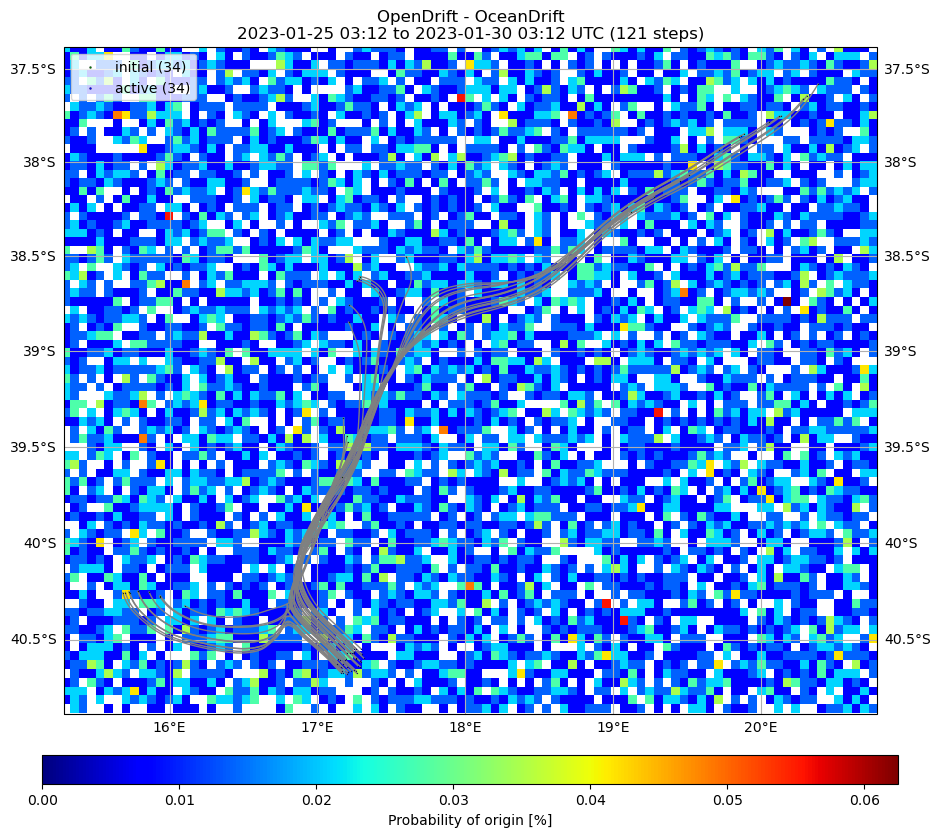

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-01-25 03:12 to 2023-01-30 03:12 UTC (121 steps)'}>,
 <Figure size 1100x901.183 with 2 Axes>)

In [49]:
of = opendrift.open_xarray(outfile)
density_fwd = of.get_histogram(pixelsize_m=5000).isel(time=0).isel(origin_marker=0)
density_fwd = density_fwd.where(density_fwd>0)
density_fwd = density_fwd/density_fwd.sum()*100
vmax = density_fwd.max()
o_hit.plot(background=density_fwd, clabel='Probability of origin [%]', fast=True, markersize=.5, lalpha=.02, vmin=0)

In [52]:
density_forwards.isel(lon_bin=40).isel(lat_bin=40)

NameError: name 'density_forwards' is not defined

In [53]:
lonbin = np.arange(np.min(back.isel(time=48).lon.values)-(0.5), np.max(back.isel(time=48).lon.values)+(0.5), 0.025)
latbin = np.arange(np.min(back.isel(time=48).lat.values)-(0.5), np.max(back.isel(time=48).lat.values)+(0.5), 0.025)

In [54]:
fwd = xr.open_dataset(outfile)

In [55]:
xfwd = fwd.isel(trajectory=hits[0])

#### Start lon and lat of FWD 'hits'

In [56]:
lon = []       # lon for 'hits'
lat = []       # lat for 'hits'

for i in range(len(xfwd.trajectory)):
    lon.append(xfwd.isel(trajectory=i).lon.values[0])
    lat.append(xfwd.isel(trajectory=i).lat.values[0])

#### Start lon and lat of all FWD runs

In [57]:
lonall = []
latall = []

for i in range(len(fwd.trajectory)):
    lonall.append(fwd.isel(trajectory=i).lon.values[0])
    latall.append(fwd.isel(trajectory=i).lat.values[0])

In [140]:
# Set the desired grid size
grid_size_lon = 0.080  # Change this to your desired grid size
grid_size_lat = 0.070

# Calculate the number of grid cells in each dimension
lon_bins = np.arange(np.min(lonall), np.max(lonall) + grid_size_lon, grid_size_lon)
lat_bins = np.arange(np.min(latall), np.max(latall) + grid_size_lat, grid_size_lat)

In [141]:
def count_points_in_grid(lon, lat, lonbins, latbins):
    
    # Count the number of points in each grid cell
    counts, _, _ = np.histogram2d(lon, lat, bins=[lon_bins, lat_bins])
    
    # Create a new DataArray with the counts and assign coordinates
    counts_dataarray = xr.DataArray(counts, coords=[('lon_bin', lon_bins[0:73]), ('lat_bin', lat_bins[0:56])])
    
    return counts_dataarray

# Call the function to count points in grid cells
grid_counts = count_points_in_grid(lon, lat, lon_bins, lat_bins)

In [69]:
len(lon_bins)

74

17:12:22 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
17:12:22 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


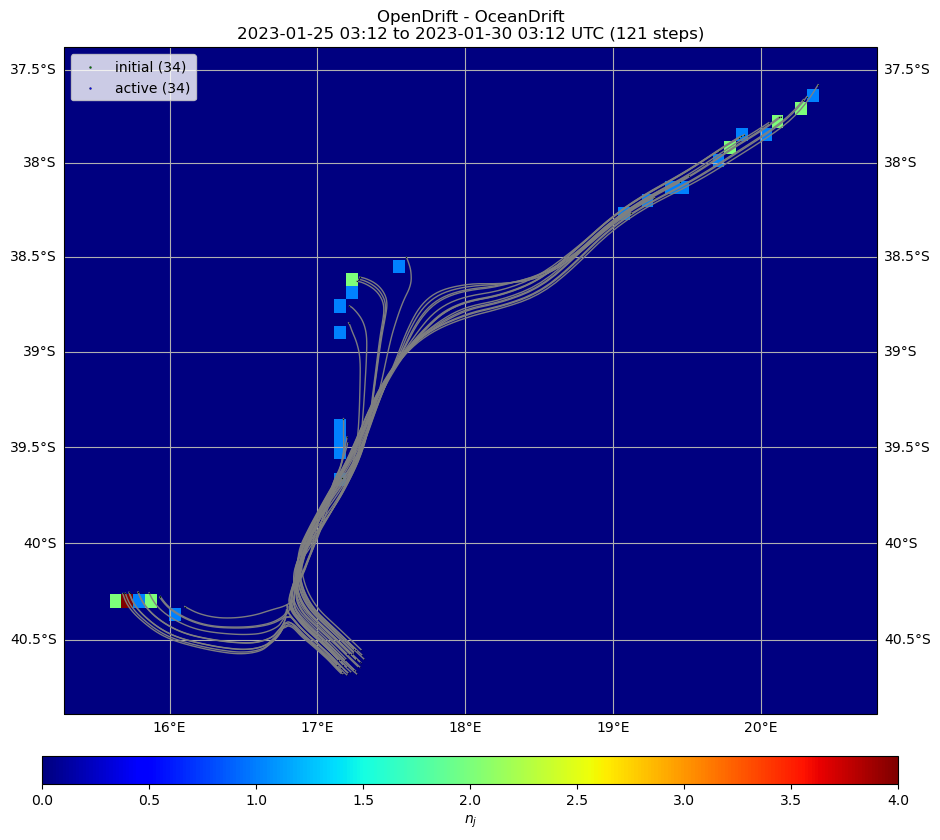

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-01-25 03:12 to 2023-01-30 03:12 UTC (121 steps)'}>,
 <Figure size 1100x901.183 with 2 Axes>)

In [71]:
o_hit.plot(background=grid_counts, clabel='$n_j$', fast=True, markersize=.5, lalpha=.02, vmin=0)

In [72]:
# Set the desired grid size
grid_size_lon = 0.080  # Change this to your desired grid size
grid_size_lat = 0.070

# Call the function to count points in grid cells
grid_counts_all = count_points_in_grid(lonall, latall, lon_bins, lat_bins)


17:12:45 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
17:12:45 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


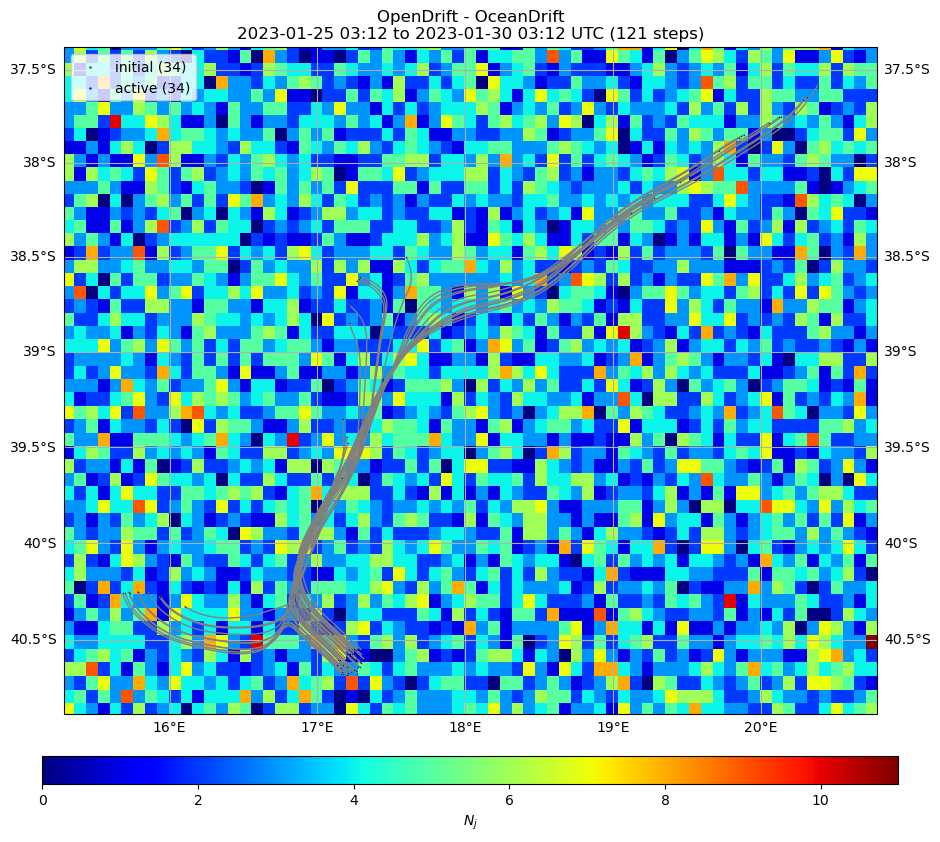

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-01-25 03:12 to 2023-01-30 03:12 UTC (121 steps)'}>,
 <Figure size 1100x901.183 with 2 Axes>)

In [73]:
o_hit.plot(background=grid_counts_all, clabel='$N_j$', fast=True, markersize=.5, lalpha=.02, vmin=0)

17:12:57 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
17:12:57 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


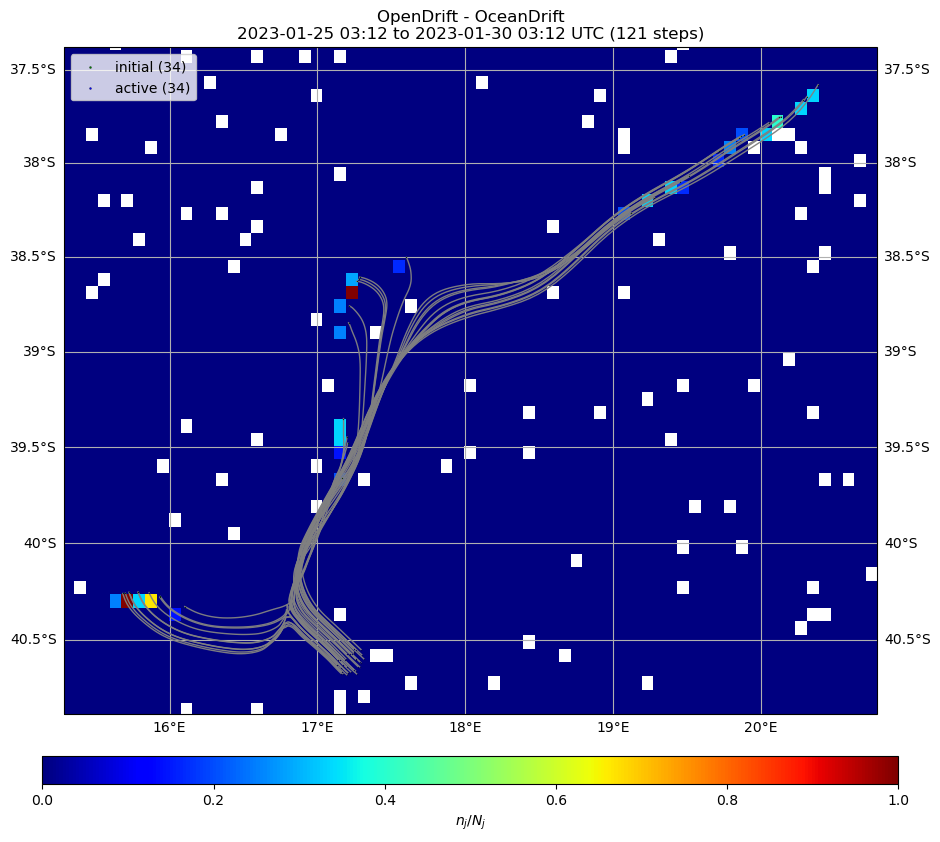

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-01-25 03:12 to 2023-01-30 03:12 UTC (121 steps)'}>,
 <Figure size 1100x901.183 with 2 Axes>)

In [74]:
o_hit.plot(background=grid_counts/grid_counts_all, clabel='$n_j / N_j$', fast=True, markersize=.5, lalpha=.02, vmin=0)

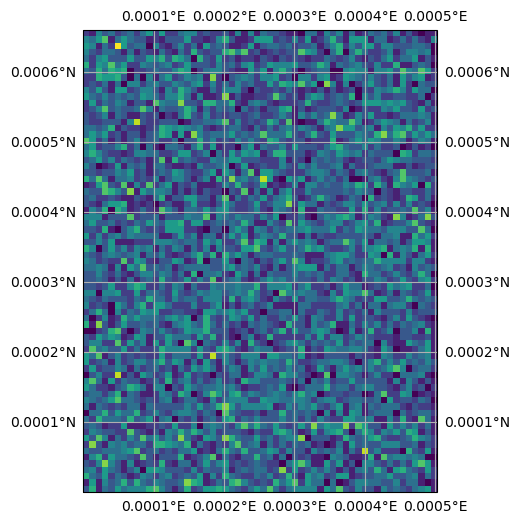

In [75]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)
ax.pcolormesh(grid_counts_all)

<xarray.DataArray 'lat' (trajectory: 500, time: 121)>
[60500 values with dtype=float32]
Coordinates:
  * trajectory  (trajectory) int32 1 2 3 4 5 6 7 ... 494 495 496 497 498 499 500
  * time        (time) datetime64[ns] 2023-01-30T03:12:08 ... 2023-01-25T03:1...
Attributes:
    units:          degrees_north
    standard_name:  latitude
    long_name:      latitude
    minval:         -40.697987
    maxval:         -37.479378

In [145]:
lonback = []       # lon for bwd
latback = []       # lat for bwd

for i in range(len(back34.trajectory)):
    lonback.append(back34.isel(trajectory=i).lon.values[-1])
    latback.append(back34.isel(trajectory=i).lat.values[-1])

In [146]:
grid_counts_back = count_points_in_grid(lonback, latback, lon_bins, lat_bins)

10:24:42 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
10:24:42 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


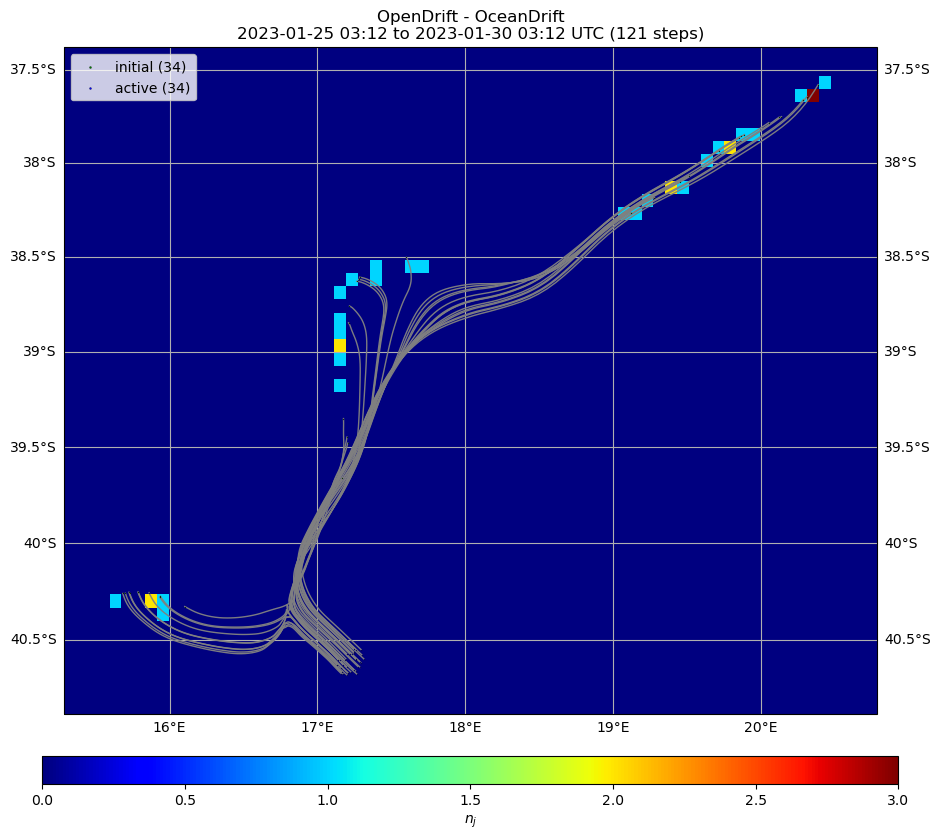

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-01-25 03:12 to 2023-01-30 03:12 UTC (121 steps)'}>,
 <Figure size 1100x901.183 with 2 Axes>)

In [147]:
o_hit.plot(background=grid_counts_back, clabel='$n_j$', fast=True, markersize=.5, lalpha=.02, vmin=0)


In [148]:
o_back = opendrift.open(outfile_bwd)

10:24:47 DEBUG   opendrift.models.oceandrift:112: No machine learning correction available.
10:24:47 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
10:24:47 DEBUG   opendrift.models.basemodel:618: Adding 5 config items from basemodel
10:24:48 DEBUG   opendrift.models.basemodel:618: Adding 36 config items from basemodel
10:24:48 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
10:24:48 DEBUG   opendrift.models.basemodel:618: Adding 14 config items from oceandrift
10:24:48 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:z
10:24:48 DEBUG   opendrift.export.io_netcdf:267: Importing from D:/backtrack/oceandrift_48h/likelihood/bwd2530jan34.nc
10:24:48 DEBUG   opendrift.models.basemodel:2449: No elements to deactivate
10:24:48 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:use_auto_landmask -> True
10:24:48 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: gen

10:24:48 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:fallback:surface_downward_x_stress -> 0
10:24:48 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:constant:surface_downward_y_stress -> None
10:24:48 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:fallback:surface_downward_y_stress -> 0
10:24:48 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:constant:turbulent_kinetic_energy -> None
10:24:48 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:fallback:turbulent_kinetic_energy -> 0
10:24:48 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:constant:turbulent_generic_length_scale -> None
10:24:48 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:fallback:turbulent_generic_length_scale -> 0
10:24:48 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: environment:constant:ocean_

17:14:55 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
17:14:55 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


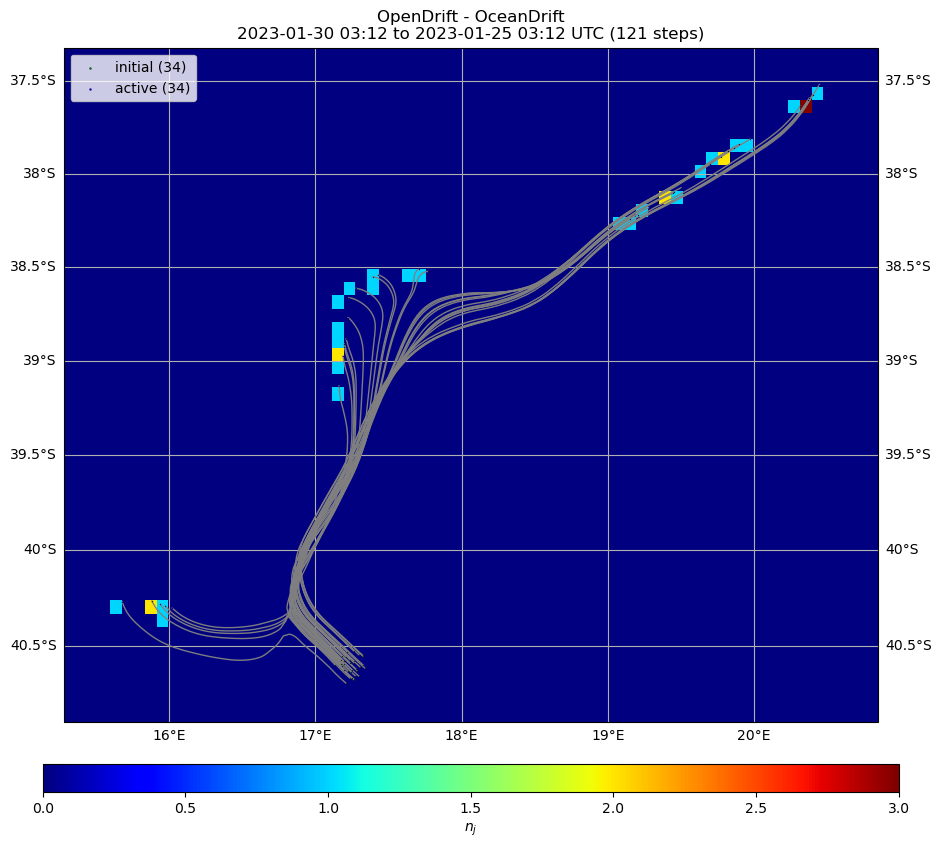

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-01-30 03:12 to 2023-01-25 03:12 UTC (121 steps)'}>,
 <Figure size 1100x910.27 with 2 Axes>)

In [86]:
o_back.plot(background=grid_counts_back, clabel='$n_j$', fast=True, markersize=.5, lalpha=.02, vmin=0)

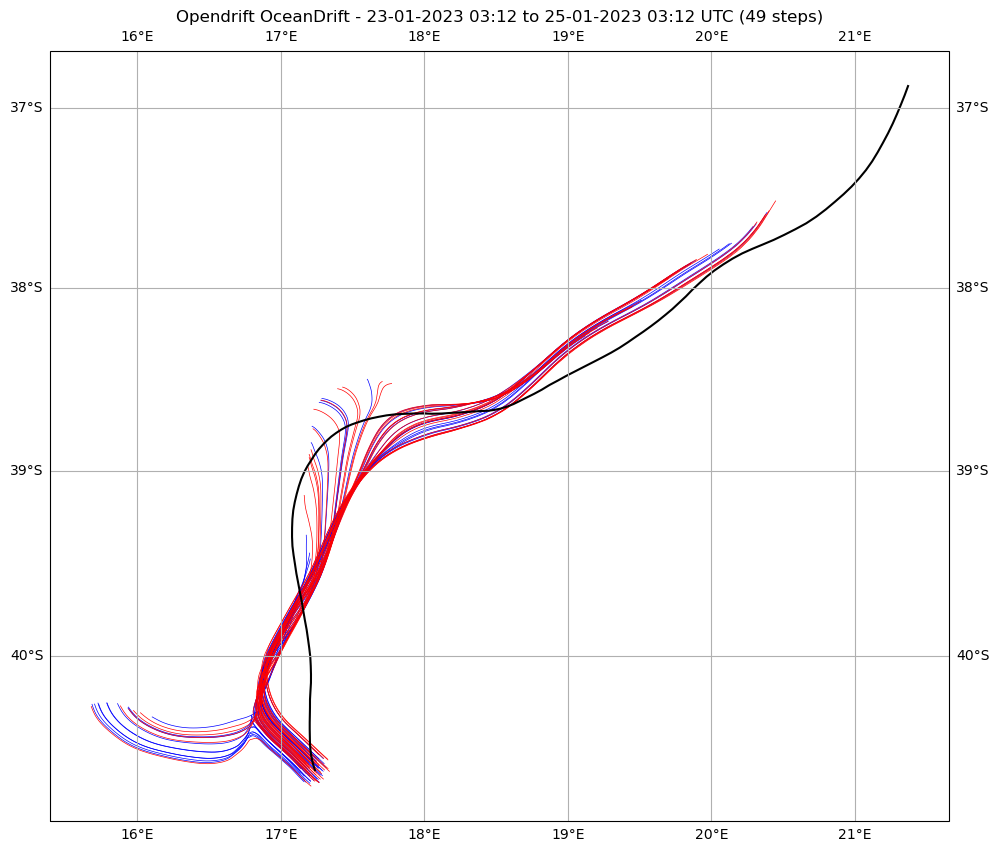

In [90]:
fig = plt.figure(1, figsize=(12,10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
ax.set_extent([18, 22, -36, -39])

ax.gridlines(draw_labels=True)
ax.coastlines(facecolor='black')
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS)


### Plotting simulations and drifter trajectories ### 

for i in hits: 
    fwd.isel(trajectory=i).traj.plot(linewidth=0.5, color='blue')

back34.traj.plot(linewidth=0.5,color='red')

# ax.plot(back192.isel(time=0).lon.values, back192.isel(time=0).lat.values, 'ro', markersize=0.5, transform=ccrs.Geodetic())
# for i in hits: 
#     ax.plot(fwd.isel(trajectory=i).isel(time=48).lon.values, fwd.isel(trajectory=i).isel(time=48).lat.values, 'bo', markersize=0.5, transform=ccrs.Geodetic())

d03.sel(time=slice('2023-01-25 03:12:08', '2023-01-30 03:12:08')).traj.plot(color='black')  

plt.gca().autoscale()
plt.title('Opendrift OceanDrift - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show() 

17:19:15 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=None, fast=True, lscale=None
17:19:15 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


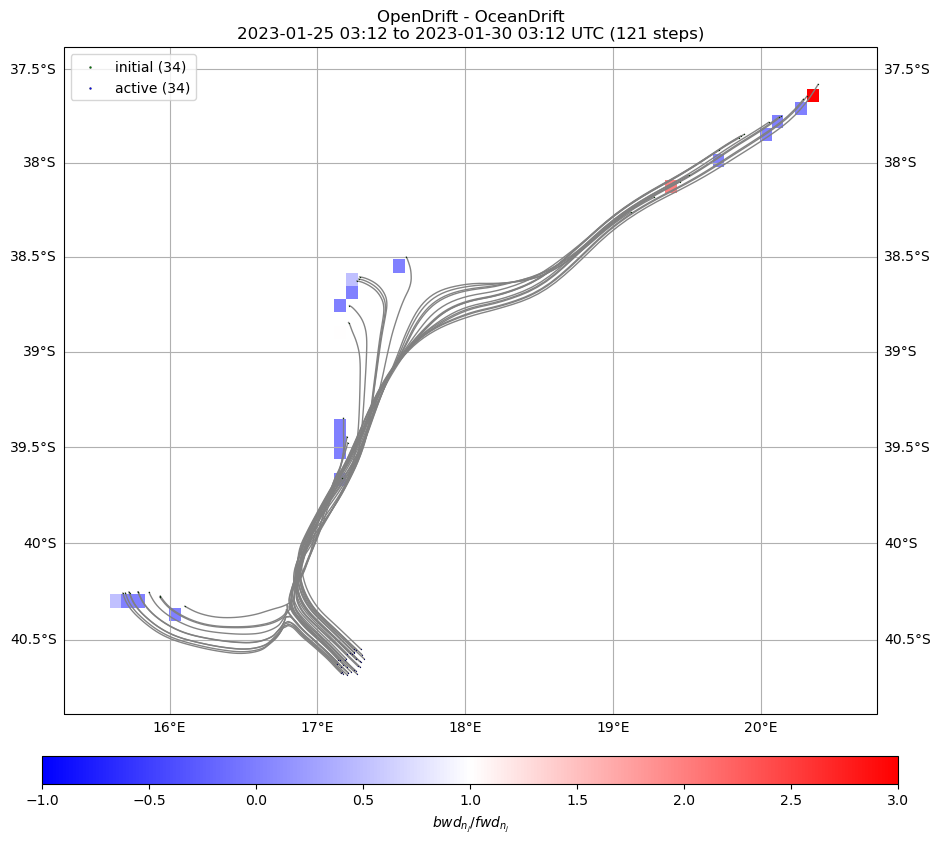

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2023-01-25 03:12 to 2023-01-30 03:12 UTC (121 steps)'}>,
 <Figure size 1100x901.183 with 2 Axes>)

In [96]:
o_hit.plot(background=grid_counts_back/grid_counts, clabel='$bwd_{n_j} / fwd_{n_j}$', cmap='bwr', fast=True, markersize=.5, lalpha=.02, vmin=-1, vmax=3)

In [89]:
grid_counts.lon_bin

<xarray.DataArray 'lon_bin' (lon_bin: 73)>
array([15.154017, 15.234017, 15.314017, 15.394017, 15.474017, 15.554017,
       15.634017, 15.714017, 15.794017, 15.874017, 15.954017, 16.034017,
       16.114017, 16.194017, 16.274017, 16.354017, 16.434017, 16.514017,
       16.594017, 16.674017, 16.754017, 16.834017, 16.914017, 16.994017,
       17.074017, 17.154017, 17.234017, 17.314017, 17.394017, 17.474017,
       17.554017, 17.634017, 17.714017, 17.794017, 17.874017, 17.954017,
       18.034017, 18.114017, 18.194017, 18.274017, 18.354017, 18.434017,
       18.514017, 18.594017, 18.674017, 18.754017, 18.834017, 18.914017,
       18.994017, 19.074017, 19.154017, 19.234017, 19.314017, 19.394017,
       19.474017, 19.554017, 19.634017, 19.714017, 19.794017, 19.874017,
       19.954017, 20.034017, 20.114017, 20.194017, 20.274017, 20.354017,
       20.434017, 20.514017, 20.594017, 20.674017, 20.754017, 20.834017,
       20.914017])
Coordinates:
  * lon_bin  (lon_bin) float64 15.15 15.23 15.31 15.39 ... 20.75 20.83 20.91